* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating modelling callbacks
* Setting up mixed precision training
* Building a feature extraction model 
* Fine-tuning the feature extraction model 


In [1]:
# Hide warning logs 
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
(train_data,test_data),ds_info = tfds.load(name="food101",
                                          split=['train','validation'],
                                          shuffle_files=True,
                                          as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                          with_info=True) # returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling food101-train.tfrecord...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling food101-validation.tfrecord...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [5]:
# Get class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

In [6]:
# Take one sample off the training data
train_one_sample = train_data.take(1)

In [7]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [8]:
# Output info about our training sample
for image,label in train_one_sample:
    print(f"""
          Image Shape: {image.shape}
          Image dtypes: {image.dtype}
          Target class from Food101 (tensor form): {label}
          class name (str form): {class_names[label.numpy()]}
          """)


          Image Shape: (512, 512, 3)
          Image dtypes: <dtype: 'uint8'>
          Target class from Food101 (tensor form): 50
          class name (str form): grilled_salmon
          


In [9]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 63,  62,  58],
        [ 59,  58,  54],
        [ 53,  52,  50],
        ...,
        [ 30,  32,  21],
        [ 33,  36,  25],
        [ 37,  40,  29]],

       [[ 54,  53,  49],
        [ 50,  49,  45],
        [ 46,  45,  43],
        ...,
        [ 28,  30,  19],
        [ 31,  34,  23],
        [ 35,  38,  27]],

       [[ 53,  52,  48],
        [ 50,  49,  45],
        [ 47,  46,  44],
        ...,
        [ 24,  26,  15],
        [ 26,  28,  17],
        [ 30,  32,  21]],

       ...,

       [[ 18,  18,   8],
        [ 14,  14,   4],
        [ 12,  12,   2],
        ...,
        [165, 185, 174],
        [165, 185, 174],
        [164, 184, 173]],

       [[ 15,  15,   5],
        [ 12,  12,   2],
        [ 12,  12,   2],
        ...,
        [161, 181, 170],
        [162, 182, 171],
        [164, 184, 172]],

       [[ 11,  11,   1],
        [  9,   9,   0],
        [ 11,  11,   1],
        ...,
        [158, 178, 16

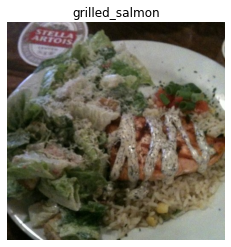

In [10]:
# Plot an image from TensorFlow Datasets
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Preprocessing images

In [11]:
# Make a function for preprocessing images
def preprocess_img(image,label,img_shape=224):
    """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
    image = tf.image.resize(image,[img_shape,img_shape]) # reshape to img_shape
    return tf.cast(image,tf.float32),label  # return (float32_image, label) tuple

In [12]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks

In [14]:
# Create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = log_dir
    )
    print(f"Saving TensorBoard logfiles to: {log_dir}")
    return tensorboard_callback

In [15]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt"  # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor = 'val_accuracy',
                                                     save_best_only=True,
                                                     save_weights_only=True, # only save model weights (not whole model)
                                                     verbose=1)

## Setup mixed precision training
Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

In [16]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

In [17]:
mixed_precision.global_policy()

<Policy "mixed_float16">

Since the global dtype policy is now "mixed_float16" ,the  model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional model 
inputs = layers.Input(shape=input_shape,name='Input_layer',dtype=tf.float16)
#x=preprocessing.Rescaling(1./255)(x)
x=base_model(inputs)
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x=layers.Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation(activation="softmax",dtype=tf.float32,name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
output_layer (Activation)    (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies

In [20]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy) # Check the dtype policy of layers

Input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [21]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                    epochs=5,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15*len(test_data)),
                                                    callbacks=[create_tensorboard_callback("training_logs","efficientnetb0_101_classes_all_data_feature_extract"),
                                                              model_checkpoint])

Saving TensorBoard logfiles to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220403-124609
Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 181s 71ms/step - loss: 1.8847 - accuracy: 0.5430 - val_loss: 1.2455 - val_accuracy: 0.6679

Epoch 00001: val_accuracy improved from -inf to 0.66790, saving model to model_checkpoints/cp.ckpt
Epoch 2/5
2368/2368 [==============================] - 165s 69ms/step - loss: 1.3669 - accuracy: 0.6469 - val_loss: 1.1396 - val_accuracy: 0.6923

Epoch 00002: val_accuracy improved from 0.66790 to 0.69227, saving model to model_checkpoints/cp.ckpt
Epoch 3/5
2368/2368 [==============================] - 170s 71ms/step - loss: 1.2308 - accuracy: 0.6778 - val_loss: 1.0792 - val_accuracy: 0.7127

Epoch 00003: val_accuracy improved from 0.69227 to 0.71266, saving model to model_checkpoints/cp.ckpt
Epoch 4/5
2368/2368 [==============================] - 174s 72ms/step - loss: 1.1387 - accuracy: 0.7001 - val_loss: 1.0653 - val_accuracy: 0.7116

Epoch 00004: val_accuracy did not improve from 0.71266
Epoch 5/5
2368/2368 [==============================] - 174s 72ms

In [22]:
model.evaluate(test_data)

790/790 [==============================] - 48s 60ms/step - loss: 1.0654 - accuracy: 0.7105


[1.0654399394989014, 0.7104950547218323]

In [23]:
def plot_loss_curves(history):
    """
  Returns separate loss curves for training and validation metrics.
  """ 
    import matplotlib.pyplot as plt
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label='val_loss')
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

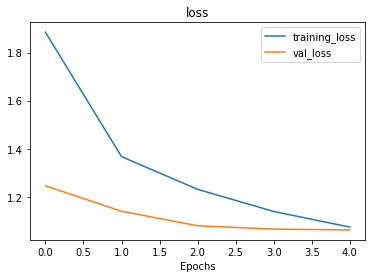

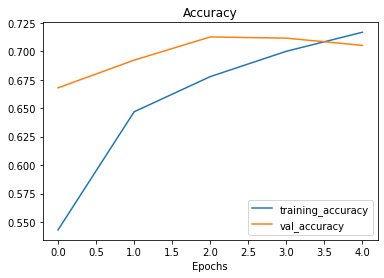

In [24]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [25]:
# Load in saved model weights and evaluate model
model.load_weights(checkpoint_path)
loaded_weights_model_results = model.evaluate(test_data)

790/790 [==============================] - 46s 59ms/step - loss: 1.0880 - accuracy: 0.7088


## Fine-tuning 

In [26]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                 patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path="fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,monitor="val_loss")

In [27]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                patience=2,
                                                verbose=1, # print out when learning rate goes down 
                                                min_lr=1e-7)

In [28]:
# Are any of the layers in our model frozen?
for layer in model.layers:
    layer.trainable = True # set all layers to trainable
 
# Recompile the model (always recompile after any adjustments to a model)
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(0.0001),
             metrics=['accuracy'])

In [29]:
# Fine tune for another 15 epochs
initial_epochs=5
fine_tune_epochs = initial_epochs+10

# Refit the model (same as model except with more trainable layers)
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                       epochs=fine_tune_epochs,
                                                       steps_per_epoch=len(train_data),
                                                       validation_data=test_data,
                                                       validation_steps=int(0.15 * len(test_data)),
                                                       callbacks=[create_tensorboard_callback("training_logs","efficientb0_101_classes_all_data_fine_tune"),
                                                                 model_checkpoint,
                                                                 early_stopping,
                                                                 reduce_lr],
                                                       initial_epoch=history_101_food_classes_feature_extract.epoch[-1])

Saving TensorBoard logfiles to: training_logs/efficientb0_101_classes_all_data_fine_tune/20220403-130536
Epoch 5/15
2368/2368 [==============================] - 402s 164ms/step - loss: 1.1852 - accuracy: 0.6903 - val_loss: 0.7333 - val_accuracy: 0.7969


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
2368/2368 [==============================] - 390s 164ms/step - loss: 0.7429 - accuracy: 0.7992 - val_loss: 0.6574 - val_accuracy: 0.8175


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
2368/2368 [==============================] - 393s 165ms/step - loss: 0.5312 - accuracy: 0.8579 - val_loss: 0.6304 - val_accuracy: 0.8212


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
2368/2368 [==============================] - 387s 162ms/step - loss: 0.3863 - accuracy: 0.8958 - val_loss: 0.6312 - val_accuracy: 0.8316
Epoch 9/15
2368/2368 [==============================] - 387s 163ms/step - loss: 0.2759 - accuracy: 0.9259 - val_loss: 0.6464 - val_accuracy: 0.8191

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 10/15
2368/2368 [==============================] - 391s 164ms/step - loss: 0.1657 - accuracy: 0.9612 - val_loss: 0.6066 - val_accuracy: 0.8313


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
2368/2368 [==============================] - 394s 166ms/step - loss: 0.1396 - accuracy: 0.9690 - val_loss: 0.6011 - val_accuracy: 0.8369


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/15
2368/2368 [==============================] - 390s 164ms/step - loss: 0.1206 - accuracy: 0.9737 - val_loss: 0.6092 - val_accuracy: 0.8353
Epoch 13/15
2368/2368 [==============================] - 387s 163ms/step - loss: 0.1079 - accuracy: 0.9774 - val_loss: 0.6120 - val_accuracy: 0.8363

Epoch 00013: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 14/15
2368/2368 [==============================] - 394s 166ms/step - loss: 0.0962 - accuracy: 0.9801 - val_loss: 0.6103 - val_accuracy: 0.8382


In [30]:
# Evaluate the model on the test data
results_fine_tune = model.evaluate(test_data)

790/790 [==============================] - 46s 58ms/step - loss: 0.6306 - accuracy: 0.8340


In [31]:
def compare_historys(original_history,new_history,initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc=original_history.history['accuracy']
    loss=original_history.history['loss']
    
    val_loss=original_history.history['val_loss']
    val_acc=original_history.history['val_accuracy']
    
    # Combine original history with new history
    total_acc=acc+new_history.history['accuracy']
    total_loss=loss+new_history.history['loss']
    
    total_val_acc=val_acc+new_history.history['val_accuracy']
    total_val_loss=val_loss+new_history.history['val_loss']
    
    # Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc,label="Training_accuracy")
    plt.plot(total_val_acc,label="Validation_accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning") # reshift plot around epochs
    plt.legend(loc="lower right")
    plt.title("Training and Validation accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(total_loss,label="Training_loss")
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning") # reshift plot around epochs
    plt.legend(loc="upper right")
    plt.title("Training and Validation loss")
    plt.xlabel('epoch')
    plt.show()

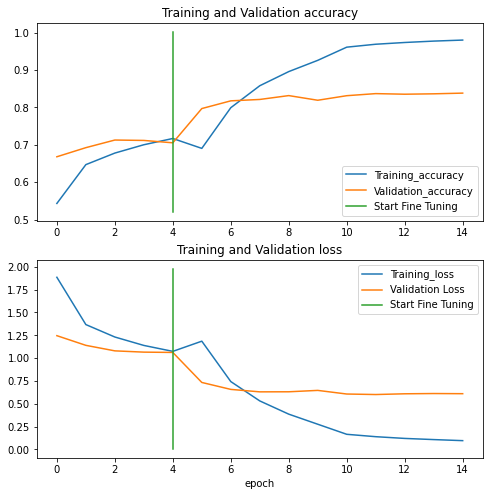

In [32]:
compare_historys(original_history=history_101_food_classes_feature_extract,
               new_history=history_101_food_classes_all_data_fine_tune,
               initial_epochs=5)

In [33]:
save_dir = "efficientnetb0_fine_tune_model"
model.save(save_dir)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [34]:
loaded_fine_tuned_model = tf.keras.models.load_model("./efficientnetb0_fine_tune_model")

In [35]:
loaded_fine_tuned_model.evaluate(test_data)

790/790 [==============================] - 49s 59ms/step - loss: 0.6306 - accuracy: 0.8340


[0.6306089758872986, 0.8340197801589966]